In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [15]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [16]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [129]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self.data_l1h0 = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)        
        
    def forward(self, x):        
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
#        self.data_l1h0 = torch.abs(h).sum(0)

        loss = nn.L1Loss()
        target =  torch.zeros(h.size())
        self.data_l1h0 = loss(h, target)                        
#        print('data_l1h0', self.data_l1h0)        

        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def l1h0_loss(self, l1_conf = 1):        
        return l1_conf*self.data_l1h0
            
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss

    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [153]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
l1_conf = 0.23
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [138]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
#            rho_loss = model.rho_loss(rho)
            l1_loss = model.l1h0_loss(l1_conf)

#            loss = model.loss(output, data) + rho_loss
            loss = model.loss(output, data) + l1_loss
#            print(l1_loss)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [139]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'l1h0_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.l1h0_loss(l1_conf).item()
#                pho_loss[k] += m.rho_loss(rho, size_average=False).item()                
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [154]:
for epoch in range(1, 11):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.925425 32: 0.936521 64: 0.925735
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.314107 32: 0.291401 64: 0.278294
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.292215 32: 0.285496 64: 0.275087
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.284579 32: 0.277729 64: 0.258751
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.263314 32: 0.256748 64: 0.238152
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.249912 32: 0.245123 64: 0.228386
Test set:
16: loss: 0.2525	l1h0_loss: 0.0000
32: loss: 0.2457	l1h0_loss: 0.0000
64: loss: 0.2288	l1h0_loss: 0.0000

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.263393 32: 0.258199 64: 0.242707
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.239350 32: 0.233284 64: 0.212246
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.237578 32: 0.228871 64: 0.192410
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.212818 32: 0.203569 64: 0.161418
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.206579 32: 0.197215 64: 0.157413
Tr

In [155]:
torch.save(models['64'].state_dict(), 'task_2_L1_' + str(l1_conf) + '.pt')    

In [159]:
models['64'] = Net(64)
models['64'].load_state_dict(torch.load('task_2_L1_0.25.pt'))


In [160]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

decoded1 = models['64'].decode(torch.eye(64)*(-1))
dec_to_plot1 = ((decoded1.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()


with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((torch.abs(encoded) > 0.2).sum(1))
    encoded[torch.abs(encoded) < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 2,  3,  5,  5,  2,  6,  1,  1,  4,  4,  3,  1,  4,  3,
         3,  2,  1,  3,  2,  3,  4,  4,  1,  0,  1,  7,  4,  3,
         5,  2,  5,  1,  4,  3,  4,  4,  3,  3,  0,  5,  3,  3,
         3,  0,  3,  3,  3,  0,  6,  1])


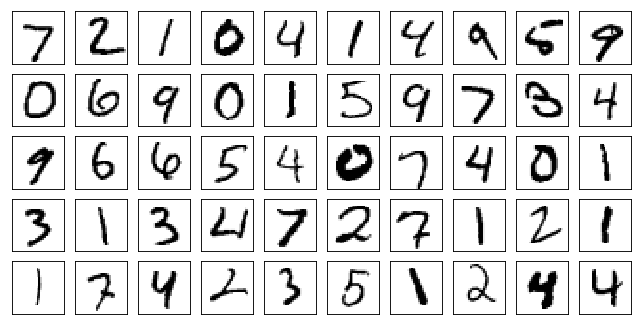

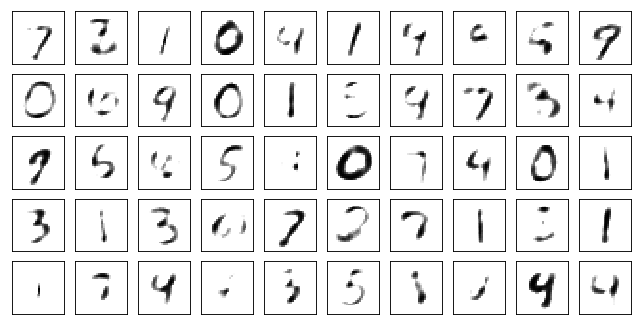

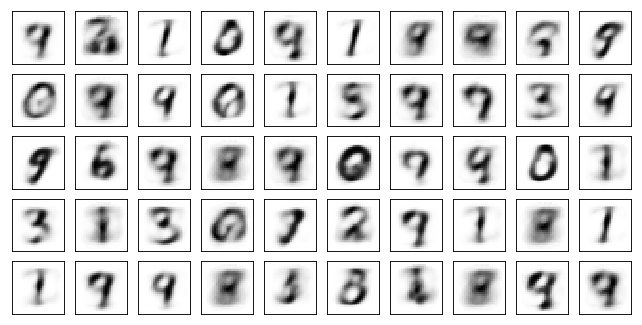

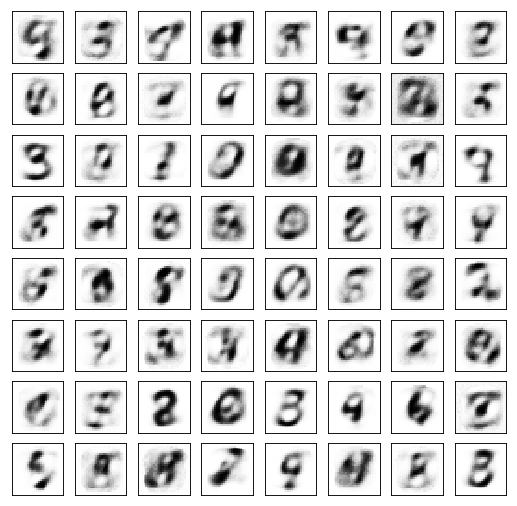

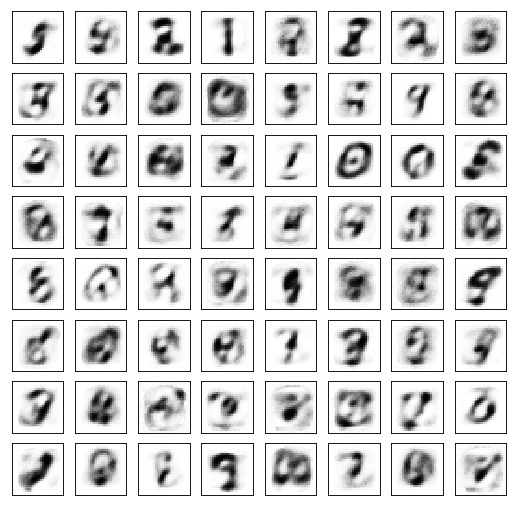

In [161]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))
plot_mnist(dec_to_plot1, (8, 8))

In [29]:
data, _ = next(iter(test_loader))
print(data.shape)
t = models['64'].E(data.view(-1, 28*28))
print(t)
print(torch.abs(t).sum(0).shape)


torch.Size([50, 1, 28, 28])
tensor([[ 0.0534,  0.0054,  0.1681,  ...,  0.3343,  0.0595,  0.0106],
        [ 0.0092,  0.0015,  0.0021,  ...,  0.0001,  0.0027,  0.0279],
        [ 0.0686,  0.0174,  0.0119,  ...,  0.0071,  0.3830,  0.1376],
        ...,
        [ 0.0832,  0.0656,  0.0206,  ...,  0.0395,  0.0557,  0.2732],
        [ 0.0229,  0.1015,  0.3874,  ...,  0.1481,  0.0018,  0.0957],
        [ 0.2344,  0.4053,  0.3160,  ...,  0.0081,  0.0056,  0.1603]])
torch.Size([64])
